In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df =  pd.read_csv('ClusteringData.csv', header=0)

In [3]:
df = df.dropna()

In [4]:
# df['계약일'] = pd.to_datetime(df['계약일'], format = '%Y-%m-%d')
# df['연도'] = df['계약일'].dt.year
# df = df.drop(['법정동명'], axis = 1)     #일단 종류가 많은 법정동명 제외
#df = df.loc[df['연도']>=2021]
# df = df.drop(['연도'], axis = 1)

In [5]:
#df = df.loc[df['임대건물명'] == '오피스텔'].dropna()

In [6]:
times = df['계약일']

In [7]:
df.set_index('계약일', inplace = True)

In [8]:
values = df.values

encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])

# encoder = LabelEncoder()
# values[:,6] = encoder.fit_transform(values[:,6])

values = values.astype('float32')

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) #값을 0~1로 떨어뜨린다

df = pd.DataFrame(scaled, columns = ['자치구명', '층', '임대면적', '보증금', '건축년도', '임대건물명','경제활동인구','기준금리','전세가격비율'])

In [9]:
df['거래일'] = times.values
df = df.sort_values(['거래일'])

In [10]:
TEST_SIZE = 200
WINDOW_SIZE = 15

train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

In [11]:
def make_dataset(data, label, window_size=15):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
from sklearn.model_selection import train_test_split

feature_cols = ['자치구명', '층', '임대면적', '건축년도', '임대건물명','경제활동인구','기준금리','전세가격비율']
label_cols = ['보증금']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 15)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((24045, 15, 8), (6012, 15, 8))

In [13]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 8), (200, 1))

In [14]:
test_feature, test_label = make_dataset(test_feature, test_label, 15)
test_feature.shape, test_label.shape

((185, 15, 8), (185, 1))

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [16]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
1502/1503 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 1: val_loss improved from inf to 0.00442, saving model to model\tmp_checkpoint.h5
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 2/200
1489/1503 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 2: val_loss improved from 0.00442 to 0.00439, saving model to model\tmp_checkpoint.h5
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 3/200
1493/1503 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 3: val_loss did not improve from 0.00439
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 4/200
1481/1503 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss improved from 0.00439 to 0.00438, saving model to model\tmp_checkpoint.h5
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0047 - val_loss: 0.00

In [17]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 0s 1ms/step


(185, 1)

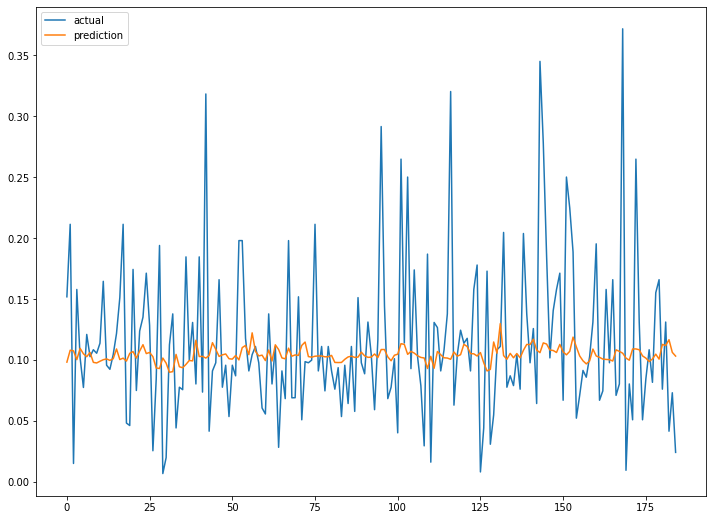

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [22]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(test_label, pred):.3f}")

MAPE: 69.441


In [23]:
from sklearn import metrics

print("MAE : " + str(metrics.mean_absolute_error(test_label, pred)))
print("MSE : " + str(metrics.mean_squared_error(test_label, pred)))
print("RMSE : " + str(np.sqrt(metrics.mean_squared_error(test_label, pred))))
print("R^2 : " + str(metrics.r2_score(test_label,pred)))

MAE : 0.045388397
MSE : 0.004168176
RMSE : 0.06456141
R^2 : -0.019674274341334508
